# Logistic Regression with Titanic Dataset
______________

## Problem: Logistic regression coefficients may lead to invalid statistical inferences
## Solutions: Test assumptions about data to prevent invalid statistical inferences 
________________

# Steps: 

## 1. Import Libraries

## 2. Import Data

## 3. Prepare Data

## 4. Test Assumptions: 
- [Assumption 1: Absence of multicollinearity](#assumption-1) 
    
    - Test 1: Correlation Matrix
    - Test 2: VIF-Variance Inflation Factor 

- [Assumption 2: Linearity of Independent Continuous Variables and Logit](#assumption-2)
    
    - Test 1: Box-Tidwell Test
    - Test 2: Visual Check 

- [Assumption 3: No Strongly Influential Outliers](#assumption-3)
    
    - Test 1: Cook's Distance (where any observation with Cook's Distance being greater than 4/n is influential) 
    - Test 2: Absolute Standardized Residuals to identify (std resid > 3) 

- [Assumption 4: Enough Data](#assumption-4)
    
    - Test 1: Enough Rows (at least 500)
    - Test 2: Enough Columns (at least 10, no more than 20)

- [Assumption 5: Correct Outcome Type](#assumption-5)
    
    - Test 1: Find output column data, check type of all unique data 

- [Assumption 6: Independence of Observations](#assumption-6)

    - Test 1: Check Residual Series
    - Test 2: Add a locally weighted scatterplot smoothing (LOWESS) line to better visualize independence


## References

- https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290


- https://github.com/kennethleungty/Logistic-Regression-Assumptions/blob/main/Logistic_Regression_Assumptions.ipynb



### 1. Import Libraries
<a name='import-libraries'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.genmod import families
# linear model used in assumptions 2, 3, and 6
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor

### 2. Import Data 
<a name='import-data'></a>

In [2]:
df = pd.read_csv('data/titanic/train.csv')

df_raw = pd.read_csv('data/titanic/train.csv')
df_titanic = pd.get_dummies(df_raw, columns = ['Pclass','Embarked', 'Sex'])

### 3. Data Preparation
<a name = 'preprocessing'><a/>


#### Preprocessing the data frame labeled 'df_raw'.
    
- Create categorical variable from 'SibSp' & 'Parch'
    
- Drop 'SibSp', 'Parch', 'PassengerId', 'Name', 'Ticket', & 'Cabin'

In [3]:
# create categorical variable for traveling alone (yes or no) 
df_raw['TravelAlone'] = np.where((df_raw['SibSp'] + df_raw['Parch']) > 0, 0, 1).astype('uint8')
# drop columns from df_raw
df_raw.drop(['SibSp','Parch', 'PassengerId', 'Name', 'Ticket', 'Cabin'],axis = 1,inplace=True)

#### Display Result

In [4]:
df_raw.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,TravelAlone
0,0,3,male,22.0,7.2500,S,0
1,1,1,female,38.0,71.2833,C,0
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,0
4,0,3,male,35.0,8.0500,S,1



#### Preprocessing the data frame labeled 'df_titanic'.
    
- Create dummy values from 'Pclass', 'Sex', & 'Embarked' columns
    
- Replace NaN values with median (median imputation)

In [5]:
# Create categorical variables and drop some variables, Remove first variable to prevent collinearity
df_titanic = pd.get_dummies(df_raw, columns=["Pclass","Embarked","Sex"], drop_first = True) 
# Fill NaN (median imputation)
df_titanic["Age"].fillna(df_titanic["Age"].median(skipna=True), inplace=True)

#### Display Result

In [6]:
df_titanic.head(5)

,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,1,0,1,1
1,1,38.0,71.2833,0,0,0,0,0,0
2,1,26.0,7.9250,1,0,1,0,1,0
3,1,35.0,53.1000,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,1,0,1,1


#### Preprocessing dataframe gathered from train.csv labeled 'df'.
- Filling NaN data
- Creating new dataframe (independent and dependent) variable x and variable y
- Removing columns named: 'PassengerId','Pclass','Name','Sex','SibSp','Parch','Ticket','Cabin','Embarked'
- Applying log() to continuous independent variables

In [7]:
# replacing the null value in Age with the average Age value
df.Age.fillna(30,inplace=True,axis='index')

# replacing the null value in Fare with the median Fare value
df.Fare.fillna(15,inplace=True,axis='index')

# filling the null values in Cabin column with the mode 
df.Cabin.fillna(df.Cabin.mode()[0],inplace=True,axis='index')

# filling the null values in Embarked column with the mode
df.Embarked.fillna(df.Embarked.mode()[0],inplace=True,axis='index')

#### Display Result

#### Creating variables for Generic Linear Model from df

In [8]:
# creat x and y 
y = df_titanic[['Survived']]
x = df_titanic[['Age','Fare','TravelAlone','Pclass_2','Pclass_3','Embarked_Q','Embarked_S','Sex_male']]

In [9]:
x.head(5)

,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,22.0,7.2500,0,0,1,0,1,1
1,38.0,71.2833,0,0,0,0,0,0
2,26.0,7.9250,1,0,1,0,1,0
3,35.0,53.1000,0,0,0,0,1,0
4,35.0,8.0500,1,0,1,0,1,1


#### - Dropping unused columns from df
#### - Applying log to continuous independent variables,
#### - Filling NaN with with median value

In [10]:
# drop data 
df = df.drop(['PassengerId','Pclass','Name','Sex','SibSp','Parch','Ticket','Cabin','Embarked'],axis = 'columns')
# apply log to continuous independent variables
df['Log_Age'] = df.Age.apply(lambda x: x * np.log(x))
# apply log to continuous independent variables
df['Log_Fare'] = df.Fare.apply(lambda x: x * np.log(x))
# fill NaN values with median value
df.Log_Fare.fillna(39,inplace=True,axis='index')

In [11]:
df_titanic_lt = df_titanic.copy()

# Define continuous variables
continuous_var = ['Age', 'Fare']

# Add logit transform interaction terms (natural log) for continuous variables e.g. Age * Log(Age)
for var in continuous_var:
    df_titanic_lt[f'Log_{var}'] = df_titanic_lt[var].apply(lambda x: x * np.log(x)) #np.log = natural log

df_titanic_lt.head()

,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male,Log_Age,Log_Fare
0,0,22.0,7.2500,0,0,1,0,1,1,68.002934,14.362261
1,1,38.0,71.2833,0,0,0,0,0,0,138.228274,304.141753
2,1,26.0,7.9250,1,0,1,0,1,0,84.710510,16.404927
3,1,35.0,53.1000,0,0,0,0,1,0,124.437182,210.922595
4,0,35.0,8.0500,1,0,1,0,1,1,124.437182,16.789660


### Display Result

In [12]:
df.head(5)

,Survived,Age,Fare,Log_Age,Log_Fare
0,0,22.0,7.2500,68.002934,14.362261
1,1,38.0,71.2833,138.228274,304.141753
2,1,26.0,7.9250,84.710510,16.404927
3,1,35.0,53.1000,124.437182,210.922595
4,0,35.0,8.0500,124.437182,16.789660


## Data Preprocessing (X & y)

In [13]:
# Define dependent and independent variables
X_cols = df_titanic.columns.to_list()[1:]
X = df_titanic[X_cols]
y = df_titanic['Survived']
# Add constant
X = sm.add_constant(X, prepend=False)

### Display Result

In [14]:
X.head()

,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male,const
0,22.0,7.2500,0,0,1,0,1,1,1.0
1,38.0,71.2833,0,0,0,0,0,0,1.0
2,26.0,7.9250,1,0,1,0,1,0,1.0
3,35.0,53.1000,0,0,0,0,1,0,1.0
4,35.0,8.0500,1,0,1,0,1,1,1.0


In [15]:
x.head(5)

,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,22.0,7.2500,0,0,1,0,1,1
1,38.0,71.2833,0,0,0,0,0,0
2,26.0,7.9250,1,0,1,0,1,0
3,35.0,53.1000,0,0,0,0,1,0
4,35.0,8.0500,1,0,1,0,1,1


# Test Assumptions

### Assumption 1: Absence of Multicollinearity 
<a name = 'assumption-1'><a/>

### [- Test 1: Correlation Matrix](#correlation)
### [- Test 2: Variance Inflation Factor](#vif)

### Test 1: Correlation Matrix
<a name = 'correlation'><a/>

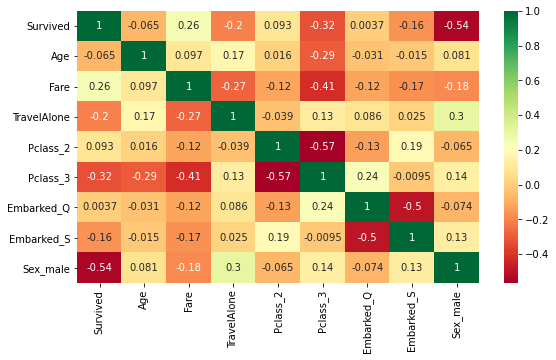

In [16]:
corr = df_titanic.corr()
plt.subplots(figsize=(9, 5))
# annot adds the values to the middle of the boxes
sns.heatmap(corr, annot = True, cmap="RdYlGn")
plt.show()

### Variance Inflation Factor
<a name = 'vif'><a/>

In [17]:
# Use variance inflation factor to identify any significant multi-collinearity, vif is 5
def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)
# call function 
calc_vif(df_titanic)

,variables,VIF
0,Survived,1.944148
1,Age,5.005814
2,Fare,1.793238
3,TravelAlone,3.030957
4,Pclass_2,1.968630
5,Pclass_3,3.524367
6,Embarked_Q,1.591633
7,Embarked_S,4.795192
8,Sex_male,3.708845


In [18]:
# Avoid dropping first variables upon get_dummies
df_test = pd.get_dummies(df_raw, columns=["Pclass","Embarked","Sex"], drop_first=False)
df_test.drop('Sex_female', axis=1, inplace=True)
df_test["Age"].fillna(df_test["Age"].median(skipna=True), inplace=True)
calc_vif(df_test)

,variables,VIF
0,Survived,1.636129
1,Age,1.247705
2,Fare,1.690089
3,TravelAlone,1.223353
4,Pclass_1,117.152079
5,Pclass_2,99.102382
6,Pclass_3,260.025558
7,Embarked_C,69.936806
8,Embarked_Q,36.792002
9,Embarked_S,91.326578


## Assumption 2: Linearity Between Independent Continuous Variables and Logit
<a name = 'assumption-2'><a/>

### Box-Tidwell Test


This assumption means that relationships between the continuous predictors and the logit (log odds) is linear.

It adds the non-linear transform of the original predictor as an interaction term to test if this addition made no better prediction.

#### A statistically significant p-value of the interaction term in the Box-Tidwell transformation means that the linearity assumption is violated

#### *If relationship is nonlinear:*

- If one variable is indeed found to be non-linear, then we can incorporate higher order polynomial terms for that variable in the regression analysis to capture the non-linearity.
- Another solution to this problem is the categorization of the independent variables. That is transforming metric variables to ordinal level and then including them in the model.

### df_titanic_2

In [19]:
# get rid of non positive integers
df_titanic_2 = df_titanic.drop(df_titanic[df_titanic.Age == 0].index)
df_titanic_2 = df_titanic_2.drop(df_titanic[df_titanic.Fare == 0].index)
df_titanic_2.head(5)

,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,1,0,1,1
1,1,38.0,71.2833,0,0,0,0,0,0
2,1,26.0,7.9250,1,0,1,0,1,0
3,1,35.0,53.1000,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,1,0,1,1


In [20]:
df_titanic_lt.head(5)

,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male,Log_Age,Log_Fare
0,0,22.0,7.2500,0,0,1,0,1,1,68.002934,14.362261
1,1,38.0,71.2833,0,0,0,0,0,0,138.228274,304.141753
2,1,26.0,7.9250,1,0,1,0,1,0,84.710510,16.404927
3,1,35.0,53.1000,0,0,0,0,1,0,124.437182,210.922595
4,0,35.0,8.0500,1,0,1,0,1,1,124.437182,16.789660


### x & y data 
- Creating dataframe with independent continuous variables for Model
- Adding constants to dataframe
- Replacing NaN values
- Creating dependent NaN values

In [21]:
# Redefine independent variables to include interaction terms
x = df_titanic_lt[['Age', 'Fare', 'Log_Age', 'Log_Fare']]
# add constant to x
x = sm.add_constant(x, prepend=False)
# remove NaN values
x.isnull().sum()
# replace NaN values 
x.Log_Fare.fillna(x.Log_Fare.median(),inplace=True,axis='index')
# y becomes survived (dependent variable)
y = df_titanic_lt['Survived']
#y = np.expand_dims(y,axis=1)
x.head(5)

,Age,Fare,Log_Age,Log_Fare,const
0,22.0,7.2500,68.002934,14.362261,1.0
1,38.0,71.2833,138.228274,304.141753,1.0
2,26.0,7.9250,84.710510,16.404927,1.0
3,35.0,53.1000,124.437182,210.922595,1.0
4,35.0,8.0500,124.437182,16.789660,1.0


### Creating logit terms with prediction values:

In [22]:
# Re-run logistic regression on original set of X and y variables
logit_results = GLM(y, X, family=families.Binomial()).fit()
predicted = logit_results.predict(X)
# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

In [23]:
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      882
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -398.95
Date:                Mon, 13 Dec 2021   Deviance:                       797.91
Time:                        17:11:27   Pearson chi2:                     933.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Age            -0.0333      0.008     -4.397      

### Plotting Logit Values Versus Independent Continuous Variables

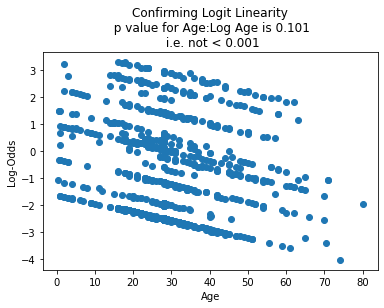

In [24]:
# Visualize predictor continuous variable vs logit values (Age)
#print('`Age` variable (p value for `Age:Log Age` is 0.101)'')
plt.scatter(x = df_titanic['Age'].values, y = log_odds);
plt.xlabel('Age')
plt.ylabel('Log-Odds')
plt.title('Confirming Logit Linearity\n  p value for Age:Log Age is 0.101 \n i.e. not < 0.001')
plt.show()

### [Visual Check](#visual)
- Confirming that there is logit NON-linearity for the `Fare` variable (p value for `Fare:Log Fare` is <0.001)

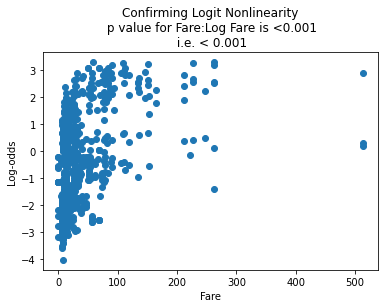

In [25]:
# Visualize predictor variable vs logit values for Fare
plt.scatter(x = df_titanic['Fare'].values, y = log_odds);
plt.xlabel("Fare")
plt.ylabel("Log-odds")
plt.title('Confirming Logit Nonlinearity\n p value for Fare:Log Fare is <0.001\n i.e. < 0.001')
plt.show()

#### Conclusion
- We are interested in the p-values for the logit transformed interaction terms of  `Age:Log_Age` and `Fare:Log_Fare`
- From the summary table above, we can see that the p value for `Fare:Log_Fare` is <0.001, which is statistically significant, whereas `Age:Log_Age` is not
- This means that there is non-linearity in the `Fare` feature, and the assumption has been violated
- We can resolve this by including a polynomial term (e.g. `Fare^2`) to account for the non-linearity

## Assumption 3: No Strongly Influential Outliers
### [Test 1: Cook's Distance](#cooks)
- Influential values are extreme individual data points that can alter the quality of the logistic regression model.
-  Cook’s Distance is a summary of how much a regression model changes when the ith observation is removed.
- A general rule of thumb is that any observation with a Cook’s distance greater than 4/n (where n = total observations) is considered to be influential, though there are even more generic cutoff values of >0.5-1.0.

### [Test 2: Standardized Residual Values](#standardized-residual)
- For outliers, we can use the absolute standardized residuals to identify them (std resid > 3)
<a name = 'assumption-3'><a/>
 

### Cook's Distance

In [26]:
# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook distance
diagnosis_df = summ_df.loc[:,['cooks_d']]

# Append absolute standardized residual values
diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Sort by Cook's Distance
diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df

,cooks_d,std_resid
0,0.000041,0.330871
1,0.000046,0.243040
2,0.001006,0.866265
3,0.000091,0.313547
4,0.000017,0.280754
...,...,...
886,0.000292,0.589428
887,0.000049,0.225427
888,0.001102,1.029623
889,0.001417,0.763489


In [27]:
# Set Cook's distance threshold
cook_threshold = 4 / len(df_titanic)
print(f"Threshold for Cook Distance = {cook_threshold}")

Threshold for Cook Distance = 0.004489337822671156


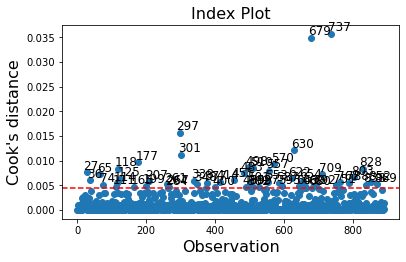

In [28]:
# Plot influence measures (Cook's distance)
fig = influence.plot_index(y_var="cooks", threshold=cook_threshold)
plt.axhline(y = cook_threshold, ls="--", color='red')
fig.tight_layout(pad=2)

### [Test 2: Standardized Residual Values](#standardized-residual)

In [66]:
# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round(100*(len(outliers) / len(df_titanic)),1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

Proportion of data points that are highly influential = 6.1%


In [67]:
# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]
prop_extreme = round(100*(len(extreme) / len(df_titanic)),1)
print(f'Proportion of highly influential outliers = {prop_extreme}%')

Proportion of highly influential outliers = 1.3%


In [68]:
# Display top 5 most influential outliers
extreme.sort_values("cooks_d", ascending=False).head()

,cooks_d,std_resid
297,0.015636,4.951289
570,0.009277,3.030644
498,0.008687,3.384369
338,0.005917,4.461842
414,0.005666,4.387731


In [69]:
# Deep dive into index 297 (extreme outlier)
df_titanic.iloc[297]

Survived         0.00
Age              2.00
Fare           151.55
TravelAlone      0.00
Pclass_2         0.00
Pclass_3         0.00
Embarked_Q       0.00
Embarked_S       1.00
Sex_male         0.00
Name: 297, dtype: float64

## Assumption 4: Enough Data
<a name = 'assumption-4'><a/>

In [34]:
# for satisfaction: 500+ rows
print("Number of rows:\n",len(df),"\n")

Number of rows:
 891 



In [71]:
# Get value counts for independent variables (mainly focus on categorical)
for col in df_titanic.columns.to_list()[1:]:
    if df_titanic.dtypes[col] == 'uint8': # Keep categorical variables only
        print(df_titanic[col].value_counts())

1    537
0    354
Name: TravelAlone, dtype: int64
0    707
1    184
Name: Pclass_2, dtype: int64
1    491
0    400
Name: Pclass_3, dtype: int64
0    814
1     77
Name: Embarked_Q, dtype: int64
1    644
0    247
Name: Embarked_S, dtype: int64
1    577
0    314
Name: Sex_male, dtype: int64


- Rule of thumb is to have at least 10-20 instances of the least frequent outcome for each predictor variable in your model
- From the value counts above, we can see that this assumption is satisfied

- Another rule of thumb is to have at least 500 observations in the entire dataset

- Overall, we have 891 observations, which is a decent dataset size to work with

## Assumption 5: Correct Outcome Type
<a name = 'assumption-5'><a/>

In [72]:
# for binary classification satisfaction: 2 outputs (0 and 1) 
print("Number of unique outcomes:\n" , y.nunique())
print("The different outcomes: \n" , y.unique()[0] ,"\n" , y.unique()[1])

Number of unique outcomes:
 2
The different outcomes: 
 0 
 1


## Assumption 6: Independence of Observations
<a name = 'assumption-6'><a/>
 
### [Test 1: Check Residual Series](#residual)
### [Test 2: Add a locally weighted scatterplot smoothing line to visualize independence ](#lowess)

### Check Residual Series
<a name = 'residual'><a/>

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      886
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -540.00
Date:                Mon, 13 Dec 2021   Deviance:                       1080.0
Time:                        17:19:38   Pearson chi2:                     893.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age           -0.1119      0.058     -1.938      0.0

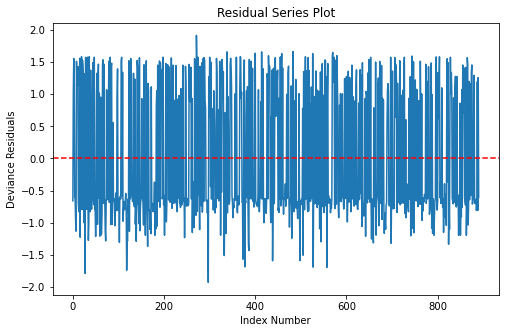

In [29]:
# Setup logistic regression model (using GLM method so that we can retrieve residuals)
logit_model = GLM(y, x, family=families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

# Generate residual series plot
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, title="Residual Series Plot",
    xlabel="Index Number", ylabel="Deviance Residuals")

# ax.plot(df_titanic_2.index.tolist(), stats.zscore(logit_results.resid_pearson))
ax.plot(df_titanic.index.tolist(), stats.zscore(logit_results.resid_deviance))
plt.axhline(y = 0, ls="--", color='red');

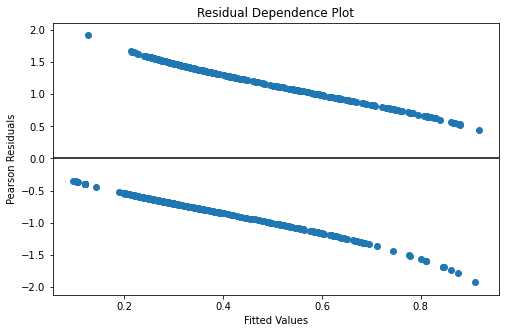

In [30]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(
    111,
    title="Residual Dependence Plot",
    xlabel="Fitted Values",
    ylabel="Pearson Residuals",
)
# ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_pearson))
ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_deviance))
ax.axis("tight")
ax.plot([0.0, 1.0], [0.0, 0.0], "k-");

### Test 2: Add a locally weighted scatterplot smoothing (LOWESS) line to better visualize independence
<a name = 'lowess'><a/>

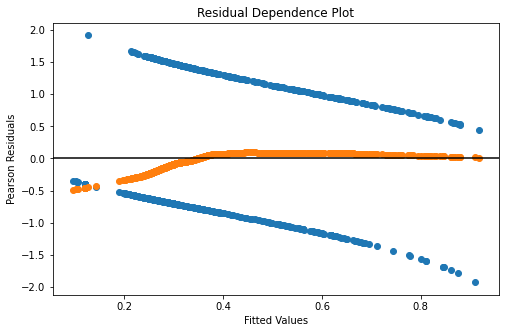

In [31]:
# Setup LOWESS function
lowess = sm.nonparametric.lowess

# Get y-values from LOWESS (set return_sorted=False)
y_hat_lowess = lowess(logit_results.resid_pearson, logit_results.mu, 
                      return_sorted = False,
                      frac=2/3)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111,
    title="Residual Dependence Plot",
    xlabel="Fitted Values",
    ylabel="Pearson Residuals",
)
# ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_pearson))
ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_deviance))
ax.scatter(logit_results.mu, y_hat_lowess)
ax.axis("tight")
ax.plot([0.0, 1.0], [0.0, 0.0], "k-");

## References

- https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290


- https://github.com/kennethleungty/Logistic-Regression-Assumptions/blob/main/Logistic_Regression_Assumptions.ipynb